In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from isochrones.mist.bc import MISTBolometricCorrectionGrid

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [80]:
bands = ["G", "BP", "RP"]

grid = MISTBolometricCorrectionGrid(bands=bands)
df = grid.df

points = [df.index.unique(level=name).to_numpy() for name in df.index.names]
shape = [x.shape[0] for x in points]
values = np.reshape(df[bands].to_numpy(), shape + [len(bands),])

In [81]:
interpolator = RegularGridInterpolator(points, values, method="linear")

In [82]:
from scipy.stats.qmc import Sobol

In [83]:
ndim = len(points)
minval = [2.5e3, 2.0, -1.0, 0.0]
maxval = [2.5e4, 6.0, 0.5, 4.0]

In [84]:
m = 20
sobol = Sobol(ndim)
scaled_inputs = sobol.random_base2(m)
inputs = np.add(minval, scaled_inputs * np.subtract(maxval, minval))

In [85]:
outputs = interpolator(inputs)

In [86]:
import seaborn as sns
import pandas as pd

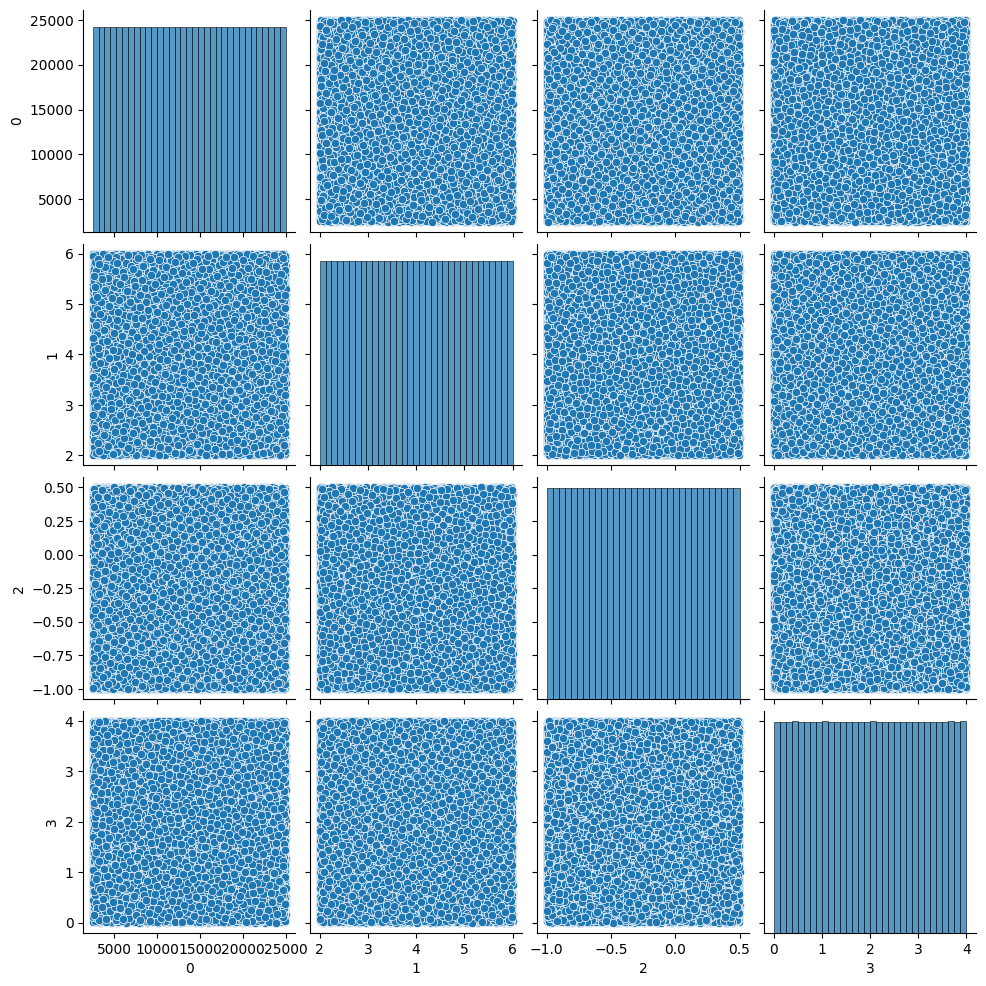

In [87]:
sns.pairplot(pd.DataFrame(inputs[:2**15]))

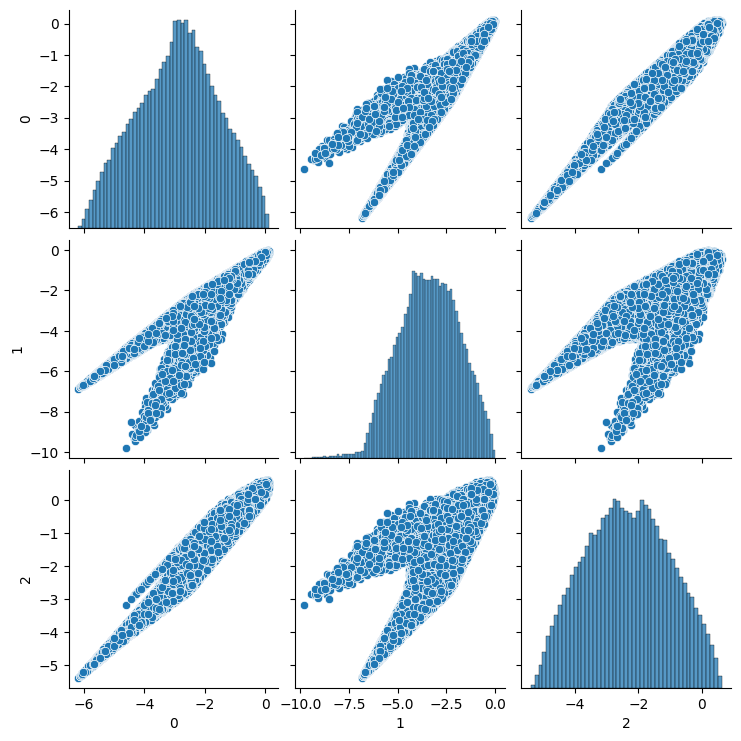

In [88]:
sns.pairplot(pd.DataFrame(outputs[:2**15]))

Our inputs are the scaled samples from the sobol sequence, these will always be between 0 and 1.

In [89]:
loc, scale = outputs.mean(0), outputs.std(0)
scaled_outputs = (outputs - loc) / scale

In [90]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.15.0


In [91]:
activation = "relu"
arch = (4, 64)

model = tf.keras.Sequential(
    [layers.Dense(arch[1], activation) for _ in range(arch[0])] +
    [layers.Dense(len(bands))]
)

2024-01-25 16:15:19.444637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18229 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2024-01-25 16:15:19.445177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18447 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


In [112]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = 'mean_squared_error'

model.compile(
    optimizer,
    loss=loss,
)

In [113]:
epochs = 100
batch_size = 256

In [114]:
%%time
history = model.fit(
    scaled_inputs,
    scaled_outputs,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2
)

Epoch 1/100
3277/3277 [==============================] - 10s 3ms/step - loss: 1.6931e-04 - val_loss: 6.6507e-05
Epoch 2/100
3277/3277 [==============================] - 8s 2ms/step - loss: 1.1240e-04 - val_loss: 7.5802e-05
Epoch 3/100
3277/3277 [==============================] - 9s 3ms/step - loss: 1.0950e-04 - val_loss: 7.2449e-05
Epoch 4/100
3277/3277 [==============================] - 10s 3ms/step - loss: 1.0253e-04 - val_loss: 1.9637e-04
Epoch 5/100
3277/3277 [==============================] - 10s 3ms/step - loss: 9.9532e-05 - val_loss: 9.4607e-05
Epoch 6/100
3277/3277 [==============================] - 11s 3ms/step - loss: 9.0501e-05 - val_loss: 1.4993e-04
Epoch 7/100
3277/3277 [==============================] - 10s 3ms/step - loss: 8.4144e-05 - val_loss: 4.1112e-05
Epoch 8/100
3277/3277 [==============================] - 10s 3ms/step - loss: 8.2681e-05 - val_loss: 4.7467e-05
Epoch 9/100
3277/3277 [==============================] - 11s 3ms/step - loss: 8.2515e-05 - val_loss: 6.551

In [115]:
import matplotlib.pyplot as plt

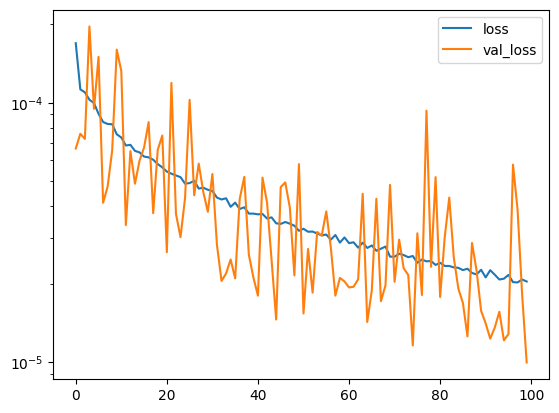

In [116]:
fig, ax = plt.subplots()

ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()
ax.set_yscale("log")

In [117]:
scaled_pred = model(scaled_inputs)
pred = loc + scale * scaled_pred

In [124]:
error = np.array(pred - outputs)

In [125]:
np.quantile(error, [.16, .5, .84], axis=0)

array([[-0.00422037, -0.00425577, -0.00162554],
       [-0.00178719, -0.00144172,  0.00065508],
       [ 0.00099778,  0.00202203,  0.00352502]])

In [135]:
error.mean()

-0.00042834517

In [136]:
error.std()

0.0044919774

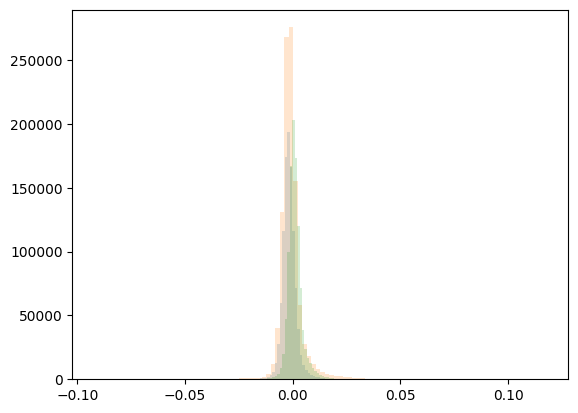

In [134]:
fig, ax = plt.subplots()

for err in error.T:
    ax.hist(err, bins=100, alpha=0.2);